# ERA5 SST Analysis with Xarray

In this notebook, we'll use xarray to analyze sea surface temperature (SST) data from the ERA5 reanalysis. We will load the data from the cloud, compute a temperature index and seasonal cycle for a defined "PNW region", calculate the trend of the temperature index, and then create a spatial correlation map between the PNW SST idx and SSTs in the broader pacific.

Most of this code is based on code written by Theo Carr for a climate diagnotics tutorial. Thanks Theo! You can access that tutorial and more on his website: https://theo.earth/whoi-climate-tutorial_2025/pages/intro.html

In [31]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmocean
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

## 1. Load Data
Here we are using weatherbench2 to access an ERA5 SST .zarr file:

In [47]:
def load_era5_from_cloud(lon_range, lat_range):
    """Load ERA5 from Google server"""

    ## open data and get SST
    data = xr.open_zarr(
        "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr",
        chunks=dict(time=1024),
    )["sea_surface_temperature"]

    ## subset for lon/lat range
    lonlat_idx = dict(longitude=slice(*lon_range), latitude=slice(*lat_range))
    data = data.sel(**lonlat_idx)

    ## load into memory
    data.load()

    ## resample from 6-hourly to monthly
    data = data.resample({"time": "MS"}).mean()

    ## transpose data (consistent with data on server)
    data = data.transpose("time", "latitude", "longitude")

    return data

In [48]:
## specify desired lon/lat range we want to load
lon_range = [190, 260] 
lat_range = [15, 70]
KWARGS = dict(lon_range=lon_range, lat_range=lat_range)

## execute read in
da = load_era5_from_cloud(**KWARGS)

In [49]:
da

<xarray.DataArray 'sea_surface_temperature' (time: 769, latitude: 36,
                                             longitude: 47)> Size: 5MB
array([[[298.98148, 298.88647, 298.71582, ..., 301.32758, 301.6175 ,
               nan],
        [298.5858 , 298.58237, 298.56696, ...,       nan,       nan,
               nan],
        [298.05905, 298.07996, 298.08112, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [271.4601 , 271.4601 ,       nan, ...,       nan,       nan,
               nan],
        [271.4601 , 271.4601 ,       nan, ...,       nan,       nan,
               nan]],

       [[298.43747, 298.19327, 297.93213, ..., 301.47186, 301.72272,
               nan],
        [298.02496, 297.94733, 297.82758, ...,       nan,       nan,
               nan],
        [297.63284, 297.55225, 297.51227, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [271.80664, 271.89587,       nan, ...,       nan,       nan,
               nan],
        [271.52765, 271.61203,       nan, ...,       nan,       nan,
               nan]],

       [[299.73257, 299.63046, 299.535  , ..., 301.61646, 301.88544,
               nan],
        [299.66895, 299.62595, 299.5822 , ...,       nan,       nan,
               nan],
        [299.31204, 298.98315, 299.36786, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [271.46017, 271.46017,       nan, ...,       nan,       nan,
               nan],
        [271.46014, 271.46017,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 288B 16.5 18.0 19.5 21.0 ... 66.0 67.5 69.0
  * longitude  (longitude) float64 376B 190.5 192.0 193.5 ... 256.5 258.0 259.5
  * time       (time) datetime64[ns] 6kB 1959-01-01 1959-02-01 ... 2023-01-01
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K

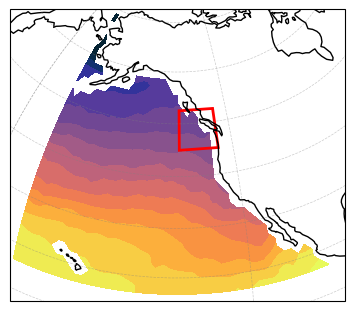

In [50]:
# PNW region bounds (0–360 lon)
region = dict(latitude=(45, 52.5), longitude=(225.5, 236.0))

fig, ax = plt.subplots(
    figsize=(5, 3),
    subplot_kw=dict(projection=ccrs.Orthographic(-135, 45)),
    layout="constrained",
)

ax.set_extent([-170, -100, 15, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution="110m")
ax.gridlines(draw_labels=False, linestyle="--", color="gray", linewidth=0.5, alpha=0.4)

# plot SST with contours
cs = ax.contourf(
    da.longitude, da.latitude, da.isel(time=-1),
    transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal,
    levels=15, extend="both"
)

# add rectangle around focused PNW region 
ax.add_patch(Rectangle(
    (region["longitude"][0], region["latitude"][0]),
    region["longitude"][1] - region["longitude"][0],
    region["latitude"][1] - region["latitude"][0],
    fill=False, edgecolor="red", linewidth=2,
    transform=ccrs.PlateCarree()
))

plt.show()

## 2. Compute seasonal cycle and temperature index:

In [34]:
# define the focused PNW region
region = dict(latitude=slice(45, 52.5), longitude=slice(225.5, 236.0))

# select the data for the region
data_subset = da.sel(region)

# compute the spatial average
latitude_radians = np.deg2rad(data_subset.latitude)
cos_lat = np.cos(latitude_radians)
idx = data_subset.weighted(weights=cos_lat).mean(["longitude", "latitude"])

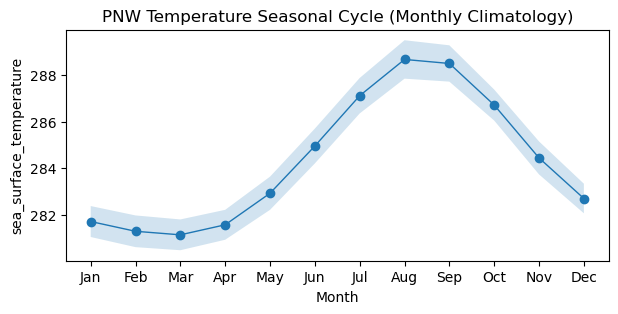

In [51]:
# mean for each calendar month
idx_clim = idx.groupby("time.month").mean("time")     #redundant based on load function... but doesnt hurt                 
idx_clim_std = idx.groupby("time.month").std("time")               # compute spread (std dev)

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(idx_clim["month"], idx_clim, marker="o", lw=1)
ax.fill_between(   #show variability envelope (standard dev)
    idx_clim["month"],
    idx_clim - idx_clim_std,
    idx_clim + idx_clim_std,
    alpha=0.2
)

# set month labels directly to avoid imports
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)

ax.set_xlabel("Month")
ax.set_ylabel(f"{idx.name or 'Index'}")
ax.set_title("PNW Temperature Seasonal Cycle (Monthly Climatology)")
plt.show()

In [57]:
# calc idx anomalies using temperature index climatology from above
idx_anom = idx.groupby("time.month") - idx_clim

# compute linear trend
polyfit_coefs = idx_anom.polyfit(dim="time", deg=1)["polyfit_coefficients"]
trend = xr.polyval(idx_anom["time"], polyfit_coefs)

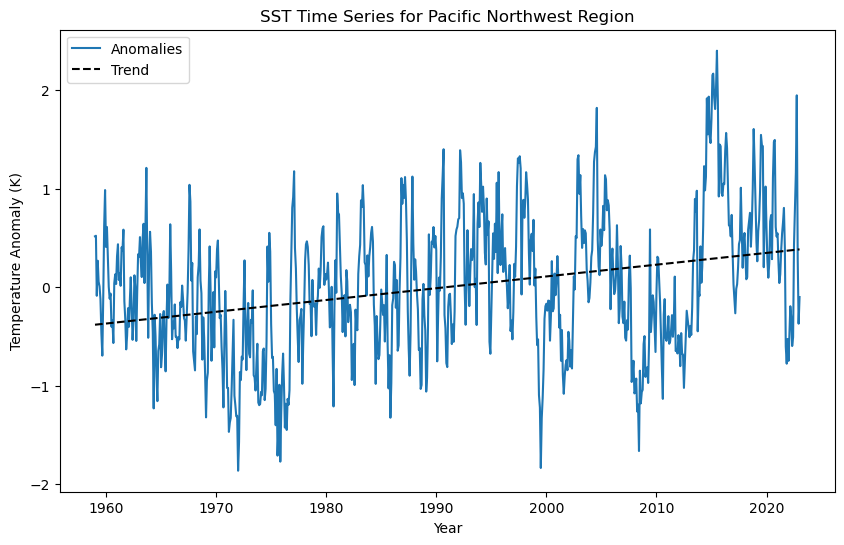

In [53]:
# plot the time series and trend
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(idx_anom.time, idx_anom, label='Anomalies')
ax.plot(trend.time, trend, label='Trend', color='black', linestyle='--')
ax.set_title("SST Time Series for Pacific Northwest Region")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature Anomaly (K)")
ax.legend()
plt.show()

## 3. Perform Correlation Analysis and Show Spatial Correlation Plot

Finally, we'll perform the correlation analysis and show the spatial correlation plot.

In [63]:
# compute anomaly for each grid cell 
data_anom = da.groupby("time.month") - da.groupby("time.month").mean()

# detrend grid anomalies inline
coefs_grid = data_anom.polyfit(dim="time", deg=1)["polyfit_coefficients"]
trend_grid = xr.polyval(data_anom["time"], coefs_grid)
data_anom_dt = data_anom - trend_grid

# detrend index anomalies inline
coefs_idx = idx_anom.polyfit(dim="time", deg=1)["polyfit_coefficients"]
trend_idx = xr.polyval(idx_anom["time"], coefs_idx)
idx_anom_dt = idx_anom - trend_idx

# correlation of detrended anomalies
corr = xr.corr(data_anom_dt, idx_anom_dt, dim="time")

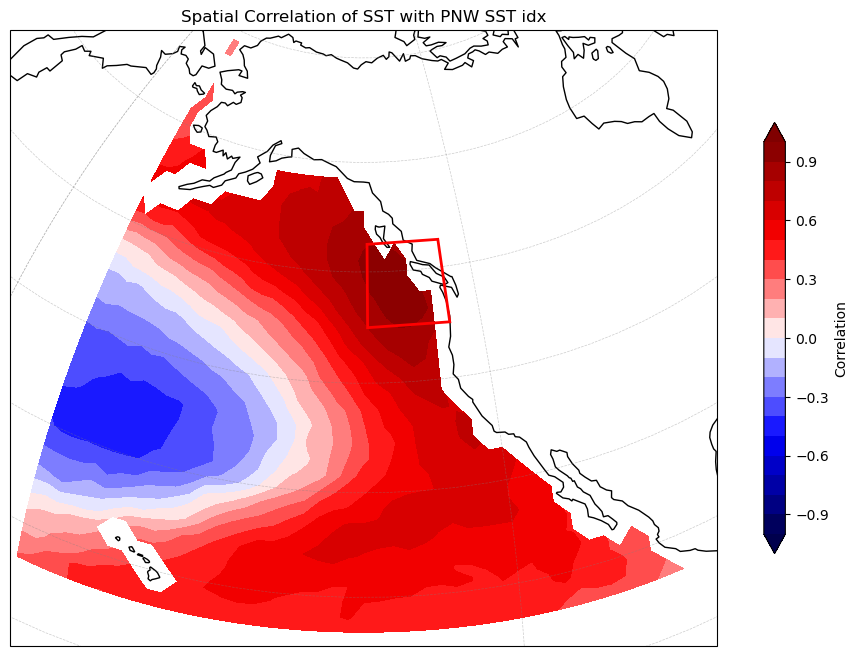

In [62]:
# create the spatial correlation plot
fig = plt.figure(figsize=(12, 8))
proj = ccrs.Orthographic(central_longitude=-135, central_latitude=45)
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.set_extent([-170, -100, 15, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution="110m")
ax.gridlines(draw_labels=False, linestyle="--", color='gray', linewidth=0.5, alpha=0.4)

# region bounds
lat_min, lat_max = 45, 52.5
lon_min, lon_max = 225.5, 236.0  # still in 0–360

pnw_box = Rectangle(
    (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
    fill=False, edgecolor="red", linewidth=2,
    transform=ccrs.PlateCarree(), zorder=10
)
ax.add_patch(pnw_box)

# plot
plot_data = ax.contourf(
    corr.longitude,
    corr.latitude,
    corr,
    transform=ccrs.PlateCarree(),
    levels=np.arange(-1, 1.1, 0.1),
    extend="both",
    cmap="seismic",
)

# add colorbar
cbar = fig.colorbar(plot_data, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Correlation')

ax.set_title("Spatial Correlation of SST with PNW SST idx")
plt.show()